# 1. 10X Visium human DLPFC dataset
In this vignette, we demonstrate how to use SpatialFuser to identify spatial domains in the DLPFC dataset. For illustration, only slice 151672 is used as an example.

Slice 151672 provides whole-transcriptome coverage with 33,438 gene features across 4,015 spatially resolved spots.

## Preparation

In [1]:
import sys
import time
from spatialFuser import *
import scanpy as sc
sys.path.append("..")

/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Hyper-Parameters setting
All hyperparameters are stored in the variable args. To display them during initialization, use the function call *args = def_training_args(show_detail=True)*.

In [2]:
# load args:
print("============================================")
print("=              Setting Params              =")
args = def_training_args()
args.epochs = 500
args.K = 6
args.step = 100
args.heads = 4
args.alpha = 0
args.lr = 2e-3

=              Setting Params              =


## Load data
SpatialFuser provides a built-in data loading and preprocessing module, *SpatialFuserDataLoader*. The required inputs include hyperparameters, data_dir (the dataset storage directory), data_tech (either “seq-based” or “image-based”), and files (a list of h5ad files to be loaded).

For spatial omics data, *SpatialFuserDataLoader* constructs a KNN adjacency graph based on the specified value of K to support graph neural network training.

For seq-based data, spatially variable genes are extracted according to n_svgs to simplify the model.

All AnnData objects are normalized, log-transformed, and subsequently converted into PyG objects for model input.

In [3]:
# load data:
print("============================================")
print("=               Loading Data               =")
loadtime = time.time()
dataLoader = SpatialFuserDataLoader(args,
                                    data_dir='/public8/lilab/student/whcai/Integration/data/10X_DLPFC',
                                    data_tech='seq-based',
                                    files=['10X_Visium_maynard2021trans_151672_data.h5ad'])
dataLoader.load_adata()
# dataLoader.remove_nan(obs_name='Region')
dataLoader.pre_processing(n_svgs=3000, k_cutoff=args.K, batch_label=[1])
dataLoader.generate_minibatch(loader_type='RandomNodeLoader', num_workers=5)

=               Loading Data               =
=         Calculating spatial graph        =
The PyG data u create is qualified
=The graph contains 28105 edges, 4015 cells=
=   7.0000 neighbors per cell on average   =
=              subgraph Info             =
=           Batch 0: 4015 nodes           =
=   6.0000 neighbors per cell on average   =
batch:[1.], node num:[4015]


## Train MCGATE

In [4]:
# train
print("============================================")
print("=              Begin to Train              =")
training_time = time.time()
adata, trainer, loss_list = train_emb(args, dataLoader)
print("=            Training Finished!            =")
print("Total time elapsed: {:.4f}s".format(time.time() - training_time))
print("============================================")

=              Begin to Train              =


Epoch500 || loss: 0.1563 || MNN num: [0]: 100%|███████████████████████████████████████| 500/500 [00:27<00:00, 18.23it/s]
/public8/lilab/student/whcai/Integration/model/SpatialFuser/spatialFuser/train.py:392: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  dataLoader.adata.uns['MCGATE_loss'] = loss_list


=            Training Finished!            =
Total time elapsed: 28.1016s


## Show trainable parameters number

In [5]:
# show param number
total_params, total_trainable_params = show_para_num(trainer.model)
param_num = {'total_params': total_params,
             'trainable_params': total_trainable_params,
             'non-trainable_params': total_params - total_trainable_params}

671,302 total parameters.
0.64M total parameters.
662,096 training parameters.
0.63M training parameters.


## Evaluation and plot based on mclust
SpatialFuser provides an evaluation module, *metrics*, for assessing tissue domain detection tasks. It treats the Region column in anndata.obs as the ground truth and, based on the provided embed_label (an array stored in anndata.obsm), automatically computes five metrics (ARI, AMI, Homogeneity, Completeness, and V-Measure) under clustering methods including Leiden, Louvain, and Mclust.

Here, we only present the spatial domains and Umap colored by Mclust.

2025-08-25 19:36:58.531929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 19:36:58.719774: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 19:37:00.167025: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/cv2/../../lib64::/usr/local/

fitting ...
  |======================================================================| 100%


/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


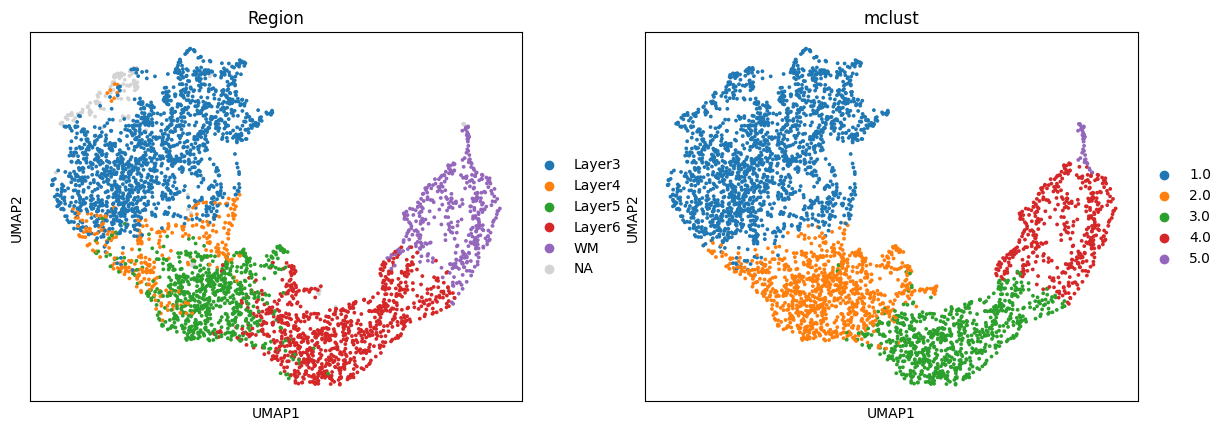

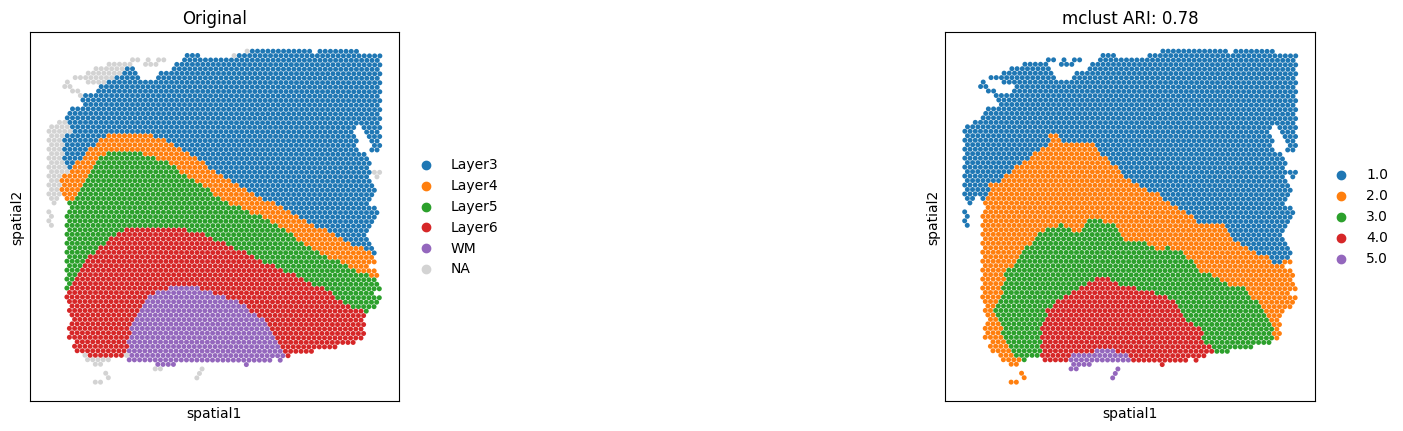

In [6]:
# evaluate and plot
leiden_result, louvain_result, mclust_result = metrics(adata,
                                                       save_loc='_151672.png',
                                                       resolution=0.1,
                                                       spot_size=0.015,
                                                       cluster_label='Region',
                                                       plot_color=["mclust"],
                                                       mclust_model='EEE',
                                                       embed_label='embedding',
                                                       vis=True,
                                                       save=True)